In [21]:
import json
import os
import sys

sys.path.append('../')
sys.path.append('../../')
sys.path.append('../src')
sys.path.append('../prompts')
sys.path.append('../src/llmperf')

# Run multiple models through the benchmarking process

In [22]:
results_dir = '../data/results/sarashina_combined'

# Analyze metrics through models

In [23]:
import pandas as pd
from typing import List
import plotly.graph_objects as go
import numpy as np

from benchmarking.utils import read_synthetic_json_files

## Read the input json file

In [24]:
df = read_synthetic_json_files(results_dir, type='summary')
df = df.set_index(['num_input_tokens','num_output_tokens','num_concurrent_requests'])
df.reset_index().sort_values(['num_input_tokens','num_output_tokens','num_concurrent_requests']).head(10)

num_input_tokens  num_output_tokens  num_concurrent_requests  \
9                128                128                        1   
17               128                128                        2   
27               128                128                        4   
16               128                128                        8   
12               128                128                       16   
44               128                128                       32   
38               128                128                       64   
23               128                128                      128   
14               128                128                      256   
54               128                128                      512   

                                                 name           model  \
9   synthetic_0_sarashina2-70b_128_128_1_stream_67...  sarashina2-70b   
17  synthetic_0_sarashina2-70b_128_128_2_stream_d3...  sarashina2-70b   
27  synthetic_0_sarashina2-70b_128_128_4_stream_8b...  sarashina2-70b   
16  synthetic_0_sarashina2-70b_128_128_8_stream_1d...  sarashina2-70b   
12  synthetic_0_sarashina2-70b_128_128_16_stream_1...  sarashina2-70b   
44  synthetic_0_sarashina2-70b_128_128_32_stream_f...  sarashina2-70b   
38  synthetic_0_sarashina2-70b_128_128_64_stream_2...  sarashina2-70b   
23  synthetic_0_sarashina2-70b_128_128_128_stream_...  sarashina2-70b   
14  synthetic_0_sarashina2-70b_128_128_256_stream_...  sarashina2-70b   
54  synthetic_0_sarashina2-70b_128_128_512_stream_...  sarashina2-70b   

    client_ttft_s_p25  client_ttft_s_p50  client_ttft_s_p75  \
9              0.5417             0.5417             0.5417   
17             0.6335             0.7344             0.8352   
27             0.8851             1.0079             1.0098   
16             0.6056             0.9150             1.2278   
12             1.4254             1.4312             1.4382   
44             1.6647             1.6784             1.6888   
38             2.5219             2.5416             2.5612   
23             2.4096             2.4518             6.5406   
14             2.4043             6.5004            10.6076   
54             6.5934            14.9188            22.7303   

    client_ttft_s_p90  client_ttft_s_p95  ...  acceptance_rate_stddev  \
9              0.5417             0.5417  ...                     NaN   
17             0.8957             0.9159  ...                  0.0000   
27             1.0107             1.0110  ...                  1.2937   
16             1.2286             1.2290  ...                  0.0730   
12             1.4454             1.4466  ...                  0.0000   
44             1.6969             1.6989  ...                  0.4652   
38             2.5771             2.5850  ...                  0.1442   
23             6.5824             6.5920  ...                  0.2754   
14            14.4862            14.5369  ...                  0.2176   
54            30.5895            30.6748  ...                  0.1842   

    num_requests_started  error_rate  number_errors  error_code_frequency  \
9                      1         0.0              0                    {}   
17                     2         0.0              0                    {}   
27                     4         0.0              0                    {}   
16                     8         0.0              0                    {}   
12                    16         0.0              0                    {}   
44                    32         0.0              0                    {}   
38                    64         0.0              0                    {}   
23                   128         0.0              0                    {}   
14                   256         0.0              0                    {}   
54                   512         0.0              0                    {}   

    client_mean_output_token_per_s  num_completed_requests  \
9                         147.3825         

In [25]:
df.reset_index().sort_values(['num_input_tokens','num_output_tokens','num_concurrent_requests']).to_excel('../data/results/sarashina2_reports/sarashina2.xlsx')

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_benchmarking_data(df, ycol, ylabel):
    df = df.reset_index()
    # Create a new column combining 'in' and 'out' into a single legend label
    df['in_out'] = df.apply(lambda row: f"({row['num_input_tokens']}, {row['num_output_tokens']})", axis=1)

    plt.figure(figsize=(8, 5))
    
    # Plot main performance metric
    sns.lineplot(data=df, x='num_concurrent_requests', y=ycol, hue='in_out', marker='o', linewidth=2)
    
    # Plot client_output_token_per_sec as a dashed line
    if ycol=='output_token_per_s_p50' and 'client_output_token_per_s_p50' in df.columns:
        sns.lineplot(data=df, x='num_concurrent_requests', y='client_output_token_per_s_p50', hue='in_out', 
                     marker='o', linestyle='dashed', alpha=0.6)
    
    # Set x-axis to log2 scale
    plt.xscale("log", base=2)
    
    # Customize x-axis ticks to show real numbers instead of 2^n notation
    xticks = sorted(df['num_concurrent_requests'].unique())
    plt.xticks(xticks, labels=[str(x) for x in xticks])
    
    # Labels and title
    plt.xlabel("Concurrency [log2 scale]")
    plt.ylabel(ylabel)
    if ycol=='output_token_per_s_p50':
        plt.title("Performance for Different (in, out) Token Combinations\n(Solid = Server, Dashed = Client)")
    else:
        plt.title("Performance for Different (in, out) Token Combinations")
    
    plt.legend(title="(in, out)", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, which="both", linestyle="--")
    
    plt.show();

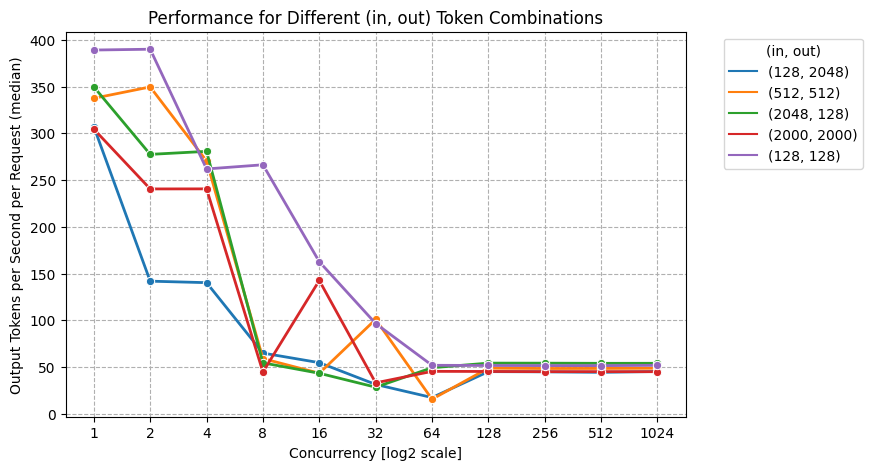

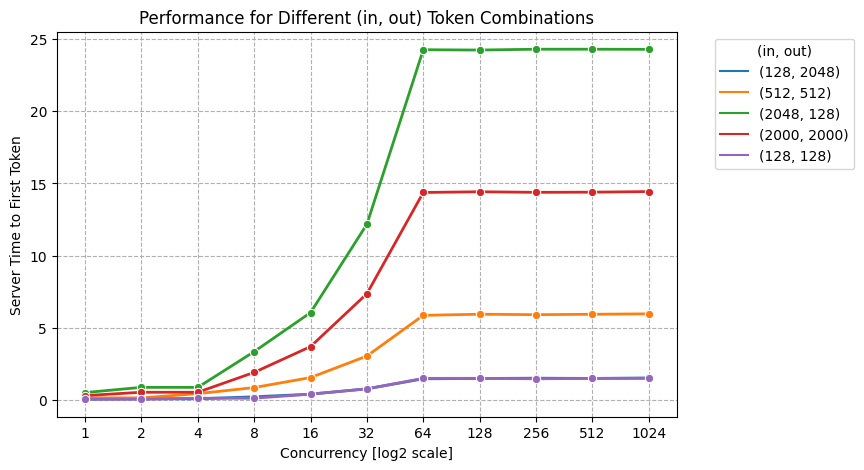

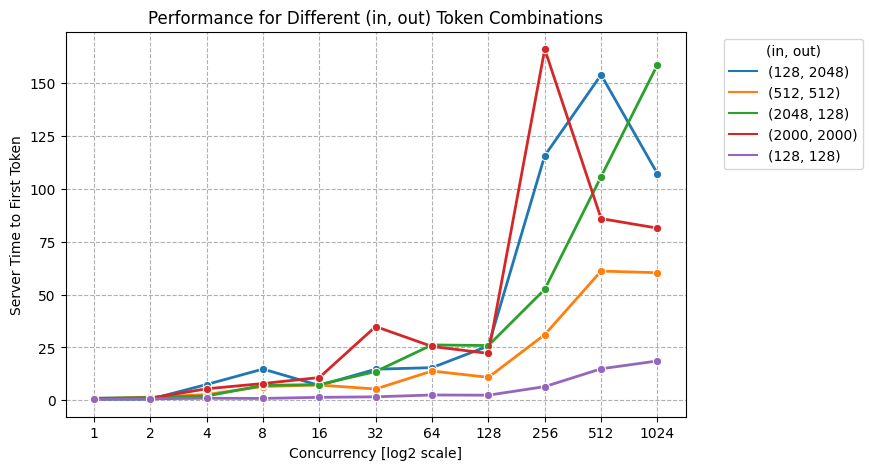

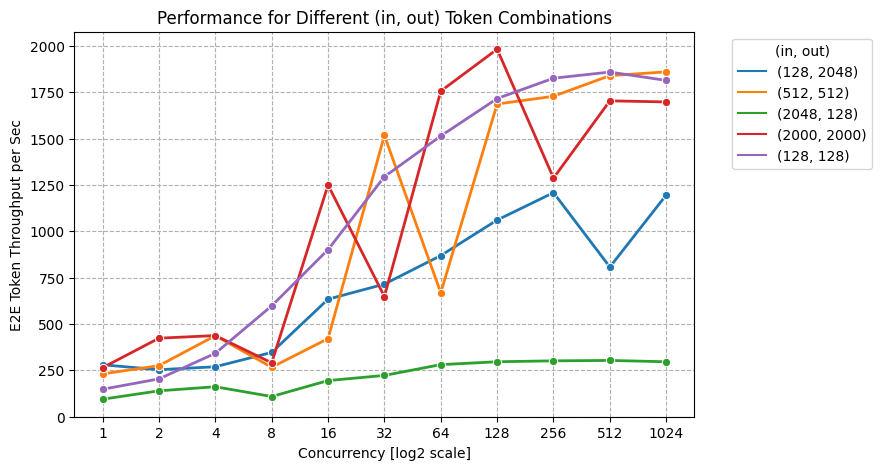

In [27]:
plot_benchmarking_data(df, 'server_output_token_per_s_p50', 'Output Tokens per Second per Request (median)')
plot_benchmarking_data(df, 'server_ttft_s_p50', 'Server Time to First Token')
plot_benchmarking_data(df, 'client_ttft_s_p50', 'Server Time to First Token')
plot_benchmarking_data(df, 'client_mean_output_token_per_s', 'E2E Token Throughput per Sec')


# Analyze switching time

__Note:__ This analysis will work if a Bundle endpoint is used. Users will be able to test and compare performance metrics for different experts.

In [ ]:
# post processing individual request json files
def read_json_files_to_df(directory: str) -> pd.DataFrame:
    data = []

    # Iterate through all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('individual_responses.json'):
            model_name = '_'.join(filename.split('_')[:2])
            file_path = os.path.join(directory, filename)
            # Read the JSON file
            with open(file_path, 'r') as file:
                json_data = json.load(file)

                # Extract relevant fields from each JSON object and append to the data list
                for item in json_data:
                    if pd.isnull(item['error_code']):
                        data.append(
                            {
                                'start_time': item['start_time'],
                                'end_time': item['end_time'],
                                'server_ttft_s': item['server_ttft_s'],
                                'model_name': model_name,
                            }
                        )

    # Create a DataFrame from the data list
    df = pd.DataFrame(data)
    return df

# Get the DataFrame
df = read_json_files_to_df(results_dir)

# transforming str to date time for sorting
df['start_time'] = pd.to_datetime(df['start_time'])
df = df.sort_values(by=['start_time'])

# transforming back to str for plotting
df['start_time'] = df['start_time'].dt.strftime(date_format='%H:%M:%S')
df

In [ ]:
# Initialize a column for the switching time
df['server_switching_time'] = None

# Group by model_name
grouped = df.groupby('model_name')

# Iterate through each group to calculate switching time
for name, group in grouped:
    if len(group) > 1:
        first_ttft = group['server_ttft_s'].iloc[0]
        mean_ttft = group['server_ttft_s'].iloc[1:].mean()
        std_ttft = group['server_ttft_s'].iloc[1:].std()
        std_ttft = 1e-16 if np.isnan(std_ttft) else std_ttft
        switching_time = first_ttft - mean_ttft
        if switching_time > (mean_ttft + 3 * std_ttft):
            df.loc[group.index[0], 'server_switching_time'] = switching_time
        else:
            None
    else:
        df.loc[group.index[0], 'server_switching_time'] = None

with pd.option_context(
    'display.max_rows',
    None,
):
    display(df)

In [ ]:
# Create a scatter plot
plt.figure(figsize=(40, 12))
sns.scatterplot(x='start_time', y='server_ttft_s', hue='model_name', data=df, s=100, alpha=0.7)

# Identify and plot the first datapoint for each model_name with a red color and bold marker
first_points = df.groupby('model_name').first().reset_index()
plt.scatter(
    first_points['start_time'],
    first_points['server_ttft_s'],
    color='red',
    s=150,
    edgecolor='black',
    linewidth=2,
    label='First TTFT',
)

# Customize the plot
plt.title('Scatter Plot of server_ttft_s Over Time by Model Name')
plt.xlabel('Start Time')
plt.ylabel('Server TTFT (s)')
plt.legend(title='Model Name', loc='upper left')
plt.xticks(rotation='vertical')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()